# An EOF analysis of AO & NAO

In [20]:
import sys
sys.path.insert(0, '_libs/')
import NEMO_tools as Nts
from Mat2Py import datenum2datetime

In [24]:
import glob
import scipy.io
import numpy as np
import netCDF4 as nc
#import NEMO_tools as Nts
from datetime import date
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic
% matplotlib inline

In [69]:
def EOF(H, nmode=10, ndim=3, reverse=1):
    '''
    Converted from MATLAB to Python 2.7 code @ 2015/06/15 - YKS
     + ndim: [LAT, LON, TIME] data (=3) or [MAP, TIME] data (=2)
     + reverse: normalized spatial pattern (=0), normalized PC (=1)
    % ======================================================================= %
    % Input
    %   H: Variable required for EOF comutation, H(LAT, LON, Time) 
    %       or H(Space, Time) is accepted.
    %   nmode: Number of modes output
    % Output
    %   EOFs: EOF Spatial Pattern
    %   PC: Timeseries cooresponding to each EOFs
    %   expvar: Explained variance
    % ======================================================================= %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/3/18
    % ======================================================================= %
    '''
    ##import scipy.linalg.eig as eig
    # Get the size of array
    if ndim == 3:
        LAT, LON, T = H.shape
    elif ndim == 2:
        LON, T = H.shape
        LAT = 1
    # Covarience
    H = np.reshape(H, [LAT*LON, T]).T
    R=np.dot(H, H.T); N = np.size(R, 0)
    # Allocation
    PC     = np.zeros([nmode, T]);
    expvar = np.zeros([nmode]);
    eof    = np.zeros([N, LAT*LON]);
    EOFs   = np.zeros([LAT, LON, nmode]);
    # Eigvector analysis
    L, E = np.linalg.eig(R)
    # Get modes
    E    = np.dot(H.T, E)
    #sq   = (np.sqrt(np.diag(L))).T
    #sq   = sq[0, :]
    sq = np.sqrt(L)
    E    = E/sq
    Z    = np.dot(E.T, H.T)
    for i in range(nmode):
        eof[i, :] = np.squeeze(E[:, i]).T
        PC[i, :]  = np.squeeze(Z[i, :])
    # Get expvar
    L = np.abs(L)
    dsum = np.sum(np.abs(L))
    # Output
    for i in range(nmode):
        expvar[i] = L[i]/dsum
        EOFs[:, :, i] = np.reshape(eof[i, :], [LAT, LON])
    if reverse==1:
        EOFs, PC = reverse_std(EOFs, PC, nmode)
    return EOFs, PC, expvar

def reverse_std(EOFs, PC, nmode):
    for i in range(nmode):
        STD = np.nanstd(PC[i, :])
        PC[i, :] = PC[i, :]/STD
        EOFs[:, :, i] = EOFs[:, :, i]*STD
    return EOFs, PC

In [70]:
def seasonal_decomp(data, method=0):
    '''
    =======================================================================
    Remove the seasonal cycle from 1D data
                            ----- created on 2015/06/15, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        data = seasonal_decomp(...)
    -----------------------------------------------------------------------
    Input:
            data
            method: removal done by anomaly (=0) or normalize (=1)
    ======================================================================= 
    '''
    for mon in range(12):
        temp_data = data[mon:len(data):12]
        if method == 0:
            data[mon:len(data):12] = data[mon:len(data):12]-np.nanmean(temp_data)
        elif method == 1:
            data[mon:len(data):12] = (data[mon:len(data):12]-np.nanmean(temp_data))/np.nanstd(temp_data)
    return data 
def seasonal_decomp3d(data, method=0):
    '''
    =======================================================================
    Remove the seasonal cycle from 3D data
                            ----- created on 2015/06/15, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        data = seasonal_decomp(...)
    -----------------------------------------------------------------------
    Input:
            data
            method: removal done by anomaly (=0) or normalize (=1)
    ======================================================================= 
    '''
    for i in range(np.size(data, 0)):
        for j in range(np.size(data, 1)):
            data[i, j, :] = seasonal_decomp(data[i, j, :], method=0)
    return data

In [98]:
def draw_smode(lon, lat, EOFs, clevs, num, ax):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=20, lon_0=90, round=True, area_thresh=5e4, ax=ax)
    proj.drawparallels(np.arange(-90, 90, 15), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    CS = proj.contourf(x, y, EOFs[:, :, num], clevs, cmap=plt.cm.RdBu_r, extend='both')
    proj.contour(x, y, EOFs[:, :, num], clevs, colors='gray', linewidths=1.5)
    proj.contour(x, y, EOFs[:, :, num], [-0.5, 0.5], colors='k', linewidths=2.5)
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.75, 0.90, "Exp. var.: %.2f"%expvar[num], transform=ax.transAxes, \
        fontsize=10, verticalalignment='top', bbox=props)
    return CS

# Read data

In [71]:
nc_name = glob.glob('_data/Reanalysis/NCEP-NCAR/*.nc')
SLP = nc.Dataset(nc_name[1])

In [72]:
# Convert netCDF time to datetime obj
d = datenum2datetime(SLP.variables['time'][:]/24)
for i in range(len(d)):
    d[i] = d[i].replace(year = d[i].year + 1800)

In [73]:
SLP.variables.keys()
y = SLP.variables['lat'][:]
x = SLP.variables['lon'][:]
slp = SLP.variables['slp'][:]
slp, x = addcyclic(slp, x)
lon, lat = np.meshgrid(x, y)

In [74]:
slp = np.transpose(slp, [1, 2, 0])
slp_np = slp[y>0, :, :]
lon_np = lon[y>0, :]
lat_np = lat[y>0, :]
slp_np = seasonal_decomp3d(slp_np, method=0)

# EOF

In [75]:
EOFs, PC, expvar = EOF(slp_np, nmode=10, ndim=3, reverse=1)

F:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:43: RuntimeWarning: invalid value encountered in sqrt


# Plot

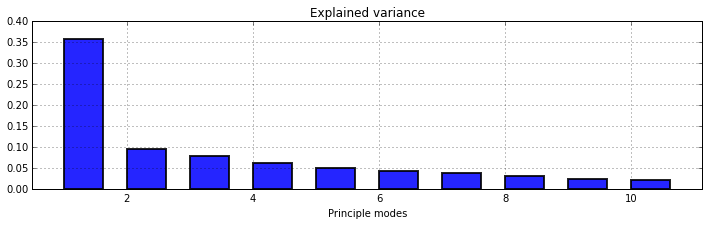

In [83]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85)
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance', fontsize=12)

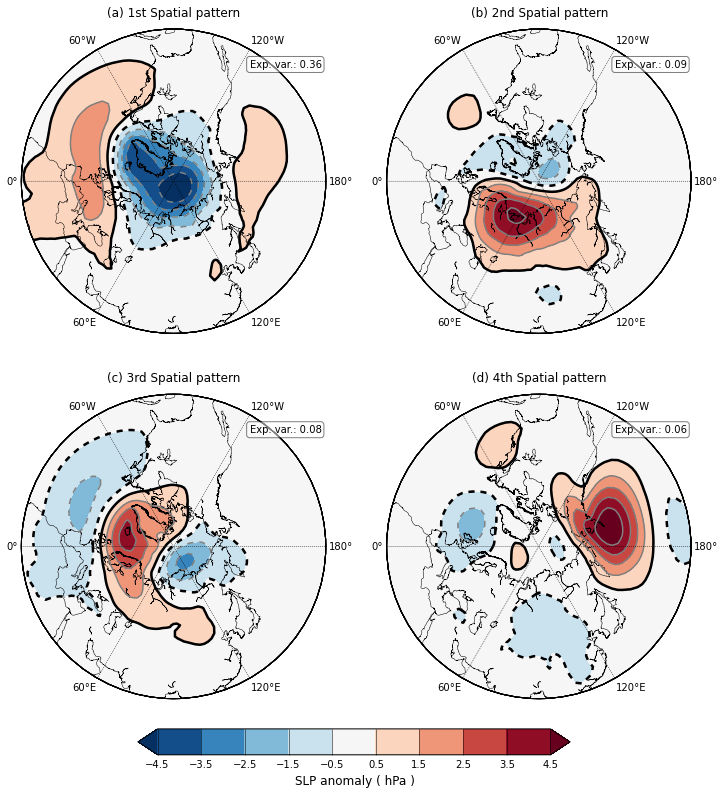

In [107]:
clevs = np.arange(-4.5, 5.5, 1)
#
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
#
CS = draw_smode(lon_np, lat_np, EOFs, clevs, 0, ax1)
ax1.set_title('(a) 1st Spatial pattern', y=1.025)
draw_smode(lon_np, lat_np, EOFs, clevs, 1, ax2)
ax2.set_title('(b) 2nd Spatial pattern', y=1.025)
draw_smode(lon_np, lat_np, EOFs, clevs, 2, ax3)
ax3.set_title('(c) 3rd Spatial pattern', y=1.025)
draw_smode(lon_np, lat_np, EOFs, clevs, 3, ax4)
ax4.set_title('(d) 4th Spatial pattern', y=1.025)
# bottom colorbar
cax  = fig.add_axes([0.26, 0.06, 0.5, 0.03])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SLP anomaly ( hPa )', fontsize=12)
CBar.ax.tick_params(axis='x', length=26)
CBar.set_ticks(clevs)

Definition of AO http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/loading.html

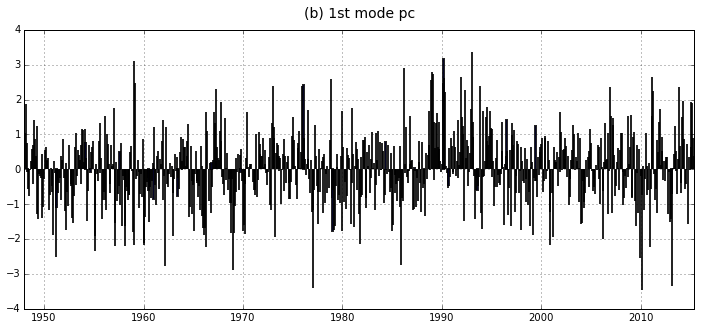

In [104]:
fig=plt.figure(figsize=(12, 5))
ax=plt.gca(); ax.grid()
ax.bar(d, PC[0, :], width=0.618, lw=2, alpha=0.85)
ax.set_title('(b) 1st mode pc', fontsize=14, y=1.025)